In [100]:
! pip install --upgrade albumentations

     |████████████████████████████████| 98 kB 3.4 MB/s 
     |████████████████████████████████| 37.1 MB 50 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import matplotlib.patches as patches
from PIL import Image
import torch
import torchvision
from torchvision.datasets import VOCDetection
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import albumentations

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
!nvidia-smi

Sun Aug 29 18:08:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### VOC Dataset

In [3]:
# CONSTANTS
SIZE = 224, 224
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
classes_dict = {'person':0, 'bird':1, 'cat':2, 'cow':3, 'dog':4, 'horse':5, 'sheep':6, 'aeroplane':7, 
                'bicycle':8, 'boat':9, 'bus':10, 'car':11, 'motorbike':12, 'train':13, 'bottle':14, 
                'chair':15, 'dining table':16, 'potted plant':17, 'sofa':18, 'tvmonitor':19}

In [11]:
class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, year, image_set, include_difficult=False, transforms=None):
        self.image_set = image_set
        assert self.image_set in ["train", "val", "trainval", "test"]
        
        self.year = str(year)
        assert self.year in ["2007", "2012"]
        
        self.include_difficult = include_difficult
        self.transforms = transforms
        self.dataset = VOCDetection(
            root="./data", 
            year=self.year, 
            image_set=self.image_set, 
            transform=None, 
            download=True
        )
        
    def __getitem__(self, idx):
        image, annotations = self.dataset[idx]
        
        # convert image to numpy array
        image = np.asarray(image)
        
        # filter annotations to include only necessary data
        objects = annotations["annotation"]["object"]
        objects = self._remove_difficult_objects(objects)
        objects = self._parse_objects(objects)

        # resize image and scale bounding box coordinates
        image, objects = self._resize_image(image, objects, SIZE)
        
        # apply transformations, convert to tensor and normalize
        if self.transforms is not None:
            image, objects = self.transforms(image, objects)
        image = torchvision.transforms.functional.to_tensor(image)

        # Normalize by mean and standard deviation of ImageNet data that our base VGG was trained on
        image = torchvision.transforms.functional.normalize(image, mean=MEAN, std=STD)
        
        return image, objects
    
    def __len__(self):
        return len(self.dataset)
    
    def collate_function(self, data):
        images = []
        objects_list = []

        for image, objects in data:
            images.append(image)
            objects_list.append(objects)

        images = torch.stack(images, dim=0)

        return images, objects_list
    
    def _remove_difficult_objects(self, objects):
        if not self.include_difficult:
            # remove only if the difficult == 1
            return [object_ for object_ in objects if object_["difficult"]!="1"]
        else:
            return objects
    
    def _parse_objects(self, objects):
        """Converts object dictionary such that it includes only 'name', 
        'bdnbox' and numerical 'label' for each object"""
        
        remove_features = ["truncated", "pose", "difficult"]
        new_objects = []
        
        for index, object_dict in enumerate(objects):
            # add numerical label
            if object_dict["name"] in classes_dict.keys():
                object_dict["label"] = classes_dict[object_dict["name"]]
                for key in remove_features:
                    object_dict.pop(key, None)
                new_objects.append(object_dict)
            else:
                # if it contains object other than specified in classes_dict
                # we don't want to remove it from labels
                continue
        return new_objects

    def _resize_image(self, img_arr, objects, size):
          """
          :param img_arr: original image as a numpy array
          :param h: resized height dimension of image
          :param w: resized weight dimension of image
          """
          # create resize transform pipeline
          transform = albumentations.Compose(
              [albumentations.Resize(height=size[1], width=size[0], always_apply=True)],
              bbox_params=albumentations.BboxParams(format='pascal_voc'))
          
          bboxes = []
          
          for object_dict in objects:
              x_min = int(object_dict["bndbox"]["xmin"])
              y_min = int(object_dict["bndbox"]["ymin"])
              x_max = int(object_dict["bndbox"]["xmax"])
              y_max = int(object_dict["bndbox"]["ymax"])
              class_id = int(object_dict["label"])
              bbox = np.array([x_min, y_min, x_max, y_max, class_id])
              bboxes.append(bbox)
              
          transformed = transform(image=img_arr, bboxes=bboxes)
          image = transformed["image"]
          bboxes = transformed["bboxes"]
          
          for i, object_dict in enumerate(objects):
              new_bndbox = {
                  "xmin":bboxes[i][0],
                  "ymin":bboxes[i][1],
                  "xmax":bboxes[i][2],
                  "ymax":bboxes[i][3]
              }
              object_dict["bndbox"] = new_bndbox
          
          return image, objects
        

In [12]:
my_voc_train = VOCDataset(2007, "train")

Using downloaded and verified file: ./data/VOCtrainval_06-Nov-2007.tar
Extracting ./data/VOCtrainval_06-Nov-2007.tar to ./data


In [13]:
train_loader = DataLoader(
    my_voc_train, 
    batch_size=64, 
    shuffle=False, 
    num_workers=2, 
    collate_fn=my_voc_train.collate_function
)

In [14]:
# Check batch
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {len(train_labels)}")

Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: 64


In [39]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
  
unorm = UnNormalize(mean=MEAN, std=STD)

Label: [{'name': 'person', 'bndbox': {'xmin': 86.33333333333334, 'ymin': 38.15384615384615, 'xmax': 130.20000000000002, 'ymax': 122.46153846153845}, 'label': 0}, {'name': 'horse', 'bndbox': {'xmin': 42.0, 'ymin': 48.0, 'xmax': 188.06666666666666, 'ymax': 206.76923076923077}, 'label': 5}]


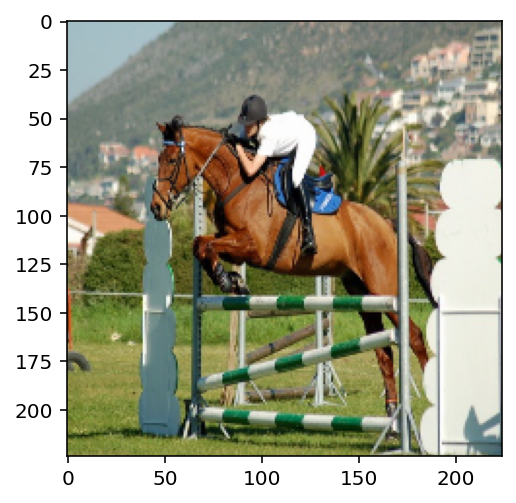

In [40]:
img = train_features[1].squeeze()
img = unorm(img)
label = train_labels[1]
plt.imshow(img.permute(1, 2, 0))
# plt.show()
print(f"Label: {label}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


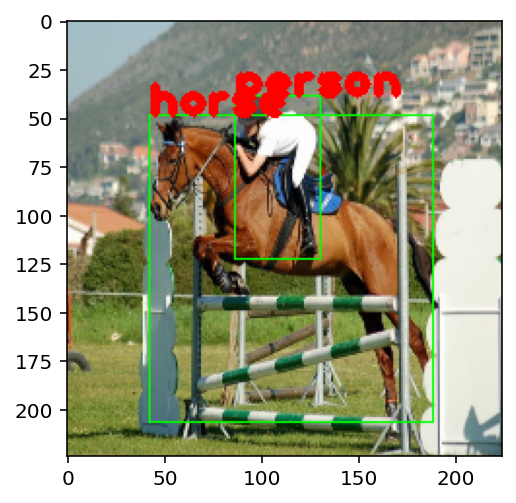

In [45]:
# utils function

FONT = cv2.FONT_HERSHEY_PLAIN
green = (0, 255, 0)
red = (255, 0, 0)
thickness = 1
font_size = 1.5
dimension = (448, 448)

def show_image_with_classes(image, labels):
      npimg = image.numpy()
      npimg = npimg.transpose((1, 2, 0)).copy() 
      for object_dict in labels:
          x = int(object_dict["bndbox"]["xmin"])
          y = int(object_dict["bndbox"]["ymin"])
          x2 = int(object_dict["bndbox"]["xmax"])
          y2 = int(object_dict["bndbox"]["ymax"])
          class_name = object_dict["name"]
          
          cv2.rectangle(npimg, (x, y), (x2, y2), green, thickness)
          cv2.putText(npimg, class_name, (x, y), FONT, font_size, red, thickness+2)
          
      
      # Display the image
      plt.imshow(npimg)

show_image_with_classes(img, label)

In [18]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter()

In [41]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = unorm(img)     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.figure(figsize = (15,15))
        plt.imshow(np.transpose(npimg, (1, 2, 0)), aspect='auto')

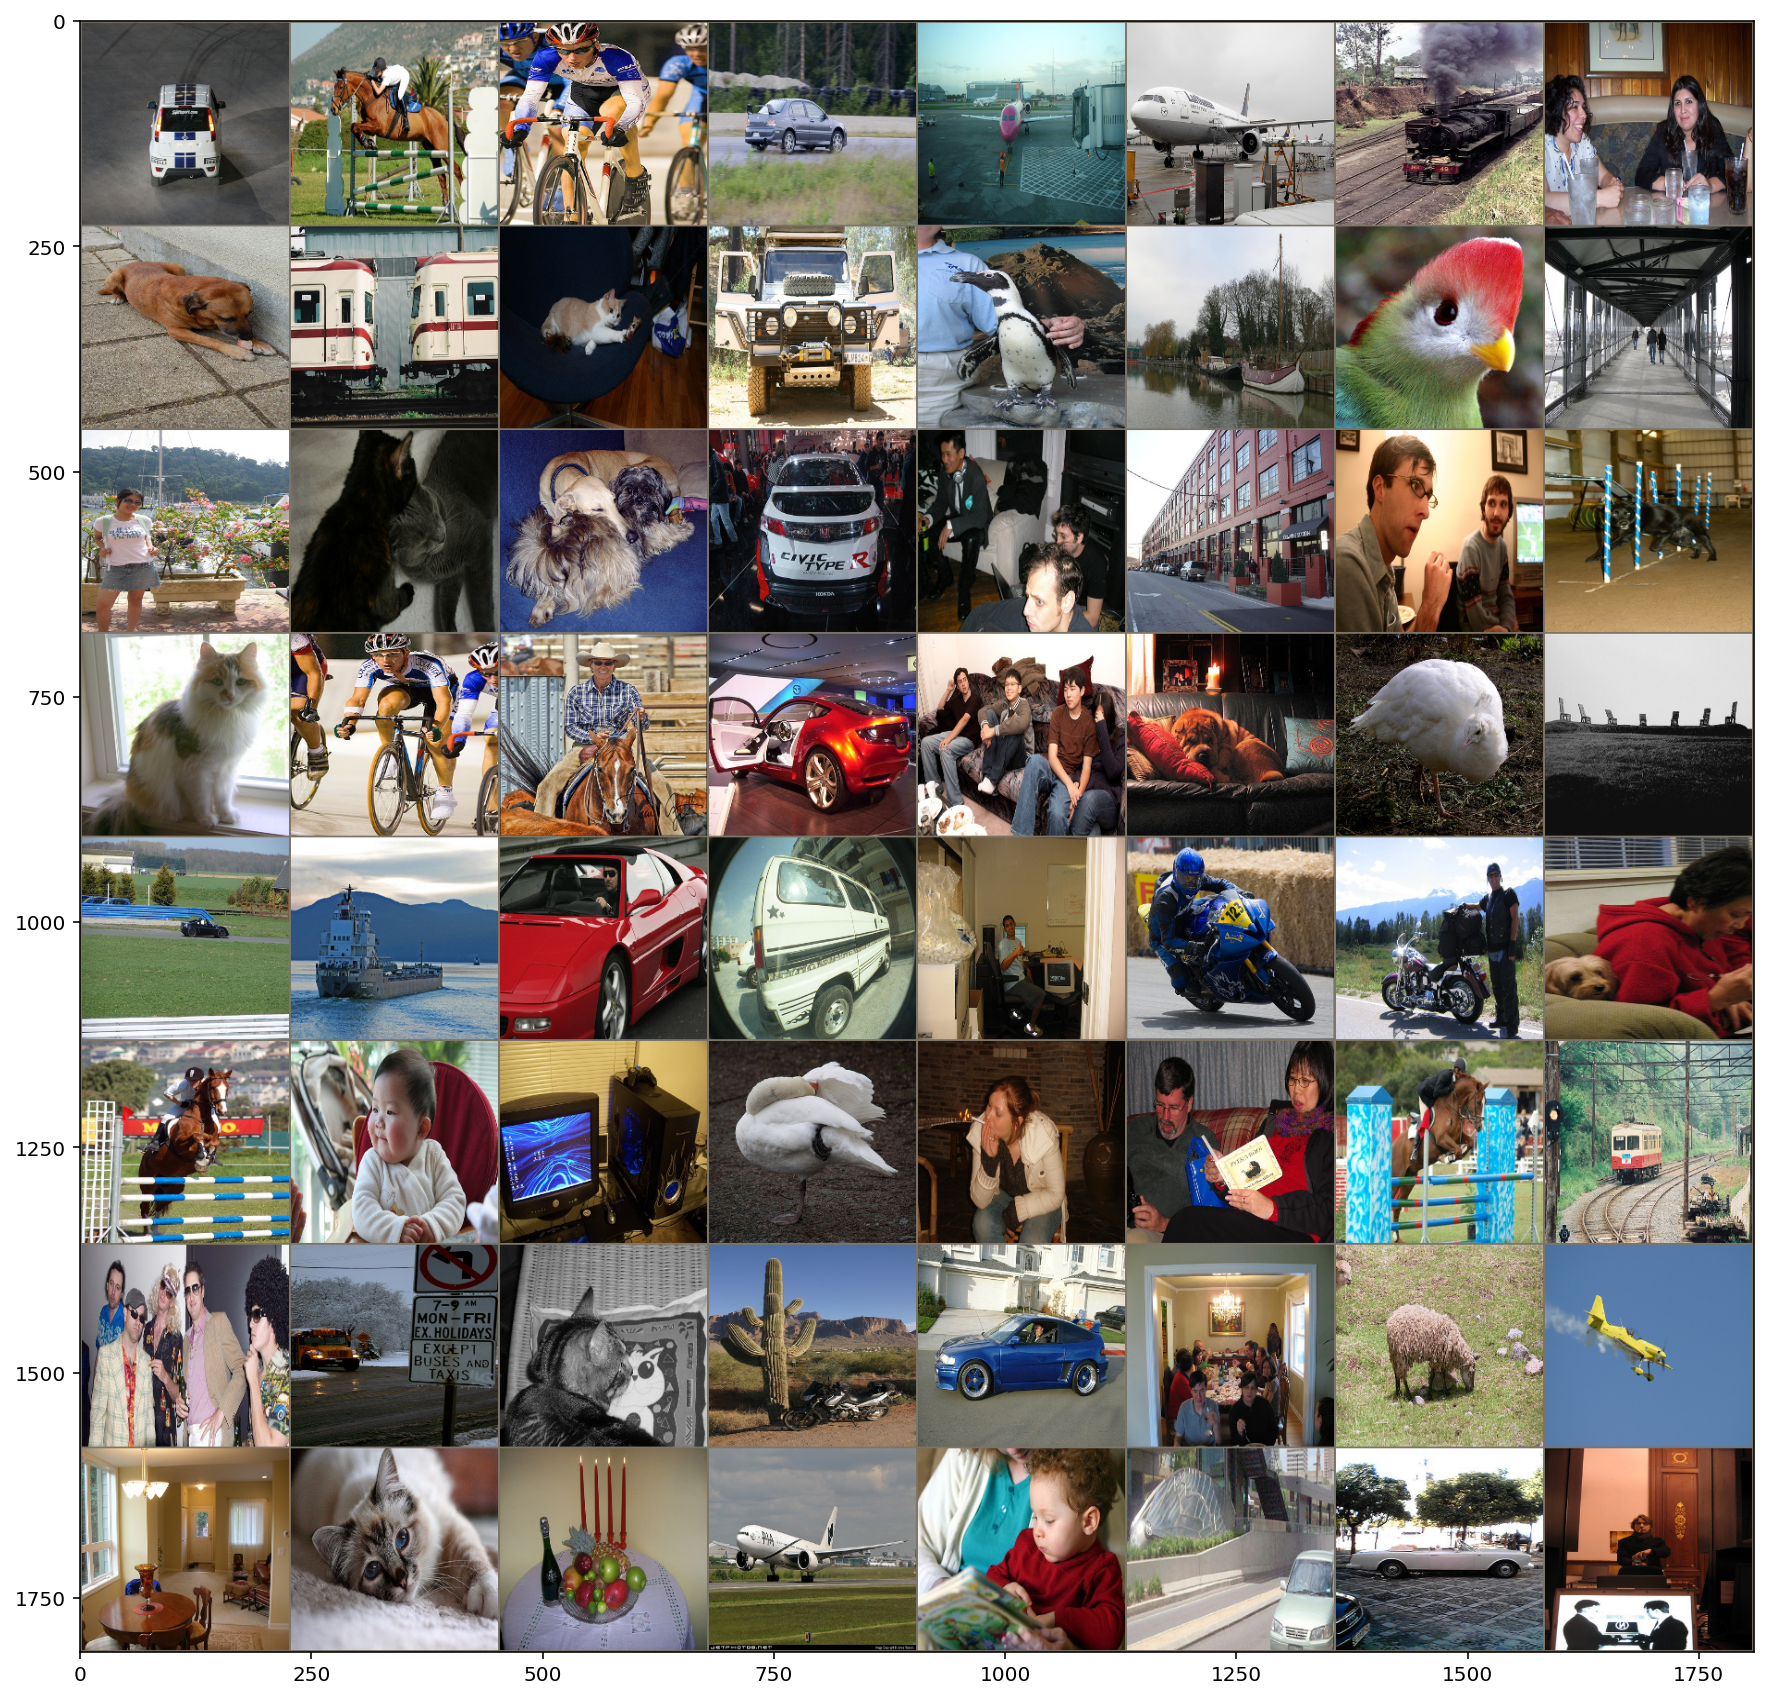

In [42]:
# get one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=False)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)